# Bus Stops by Neighborhood
### By Griffin Hurt

Dataset: [Pittsburgh Regional Transit Transit Stops](https://data.wprdc.org/dataset/prt-of-allegheny-county-transit-stops)

Let's get started by loading in the neighborhood data with geopandas.

In [12]:
import geopandas as gpd
import pandas as pd

# Load in the neighborhoods
neighborhood_data = gpd.read_file('data/pittsburghpaneighborhoods-/Neighborhoods_.shp')

neighborhood_data.head(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
0,1,233,42,003,140500,3,420031405003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7968760.0,a642a6b6-a2a9-48d5-acf2-3e2ce87d4bc0,8.153647e+06,14047.065024,"POLYGON ((-79.90560 40.45522, -79.90553 40.455..."
1,2,203,42,003,140100,3,420031401003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,34078712.0,20d4605b-258e-441a-a57e-a28fdabb6d30,3.407739e+07,30347.886823,"POLYGON ((-79.91309 40.43804, -79.91321 40.438..."
2,3,86,42,003,101700,2,420031017002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12751163.0,bf4065e7-c29c-48bd-b529-e7fd99077238,1.275116e+07,14577.441571,"POLYGON ((-79.93457 40.47217, -79.93455 40.472..."


We see that the neighborhood name is contained in the column labeled "hood" and the borders of the neighborhood are in "geometry". We can use the polygon object in "geometry" later to determine whether a bus stop is located in a neighborhood or not with `polygon.contains(stop)`.

Next we need to load in the bus stops.

In [15]:
# Load in the bus stops
stops = gpd.read_file('data/paac_stops_1909/PAAC_Stops_1909.shp')
# Filter stops to be bus stops only
stops = stops[stops["Mode"] == "Bus"]

stops.head(3)

,StopID,Stop_name,CleverID,Direction,Timepoint,Routes_ser,Routes_cou,Latitude,Longitude,Mode,Shelter,Stop_type,On_avwk_FY,Off_avwk_F,On_avwk__1,Off_avwk_1,AvgWkdy_De,geometry
0,E00175,26TH ST AT PENN AVE FS (SPRING WAY),2593.0,Inbound,N,"54, 88, 91",3.0,40.454635,-79.978170,Bus,No Shelter,Bus Stop,34.531580,43.900523,35,44,0.03,POINT (1348499.759 416298.200)
1,E00180,28TH ST AT LIBERTY AVE,2161.0,Inbound,N,54,1.0,40.456288,-79.974651,Bus,No Shelter,Bus Stop,1.304759,10.216890,1,10,0.03,POINT (1349493.900 416875.511)
2,E00270,32ND ST AT SPRING WAY,2410.0,Outbound,N,"54, 88, 91",3.0,40.460347,-79.969436,Bus,No Shelter,Bus Stop,13.184478,33.410865,13,33,0.04,POINT (1350981.820 418317.228)


It would be wonderful if the `Point` classes in the "geometry" column used latitude and longitude, but they don't, so we'll have to do that manually.

Next we're going to simplify the unwieldy geopandas dataset into a pandas dataset that is more manageable.

In [18]:

neighborhoods = pd.DataFrame(columns = ["Neighborhood", "Geometry", "Stops"])
neighborhoods["Neighborhood"] = neighborhood_data["hood"]
neighborhoods["Geometry"] = neighborhood_data["geometry"]
neighborhoods["Stops"] = 0

neighborhoods.head(3)

,Neighborhood,Geometry,Stops
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",0
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",0


Now we're ready to iterate through the bus stops and determine how many of them are in each neighborhood.

In [21]:
# Point class so we can fix the incorrect point geometry
from shapely.geometry import Point

for i, stop in stops.iterrows():
    # First, fix the point by using the correct latitude and longitude
    pt = Point(stop["Longitude"], stop["Latitude"])
    for j, neighborhood in neighborhoods.iterrows():
        # Check if the neighborhood has the stop
        if neighborhood["Geometry"].contains(pt):
            neighborhoods.at[j, 'Stops'] = neighborhood["Stops"] + 1
            # Break to save computation time
            break

neighborhoods.head(3)

,Neighborhood,Geometry,Stops
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",15
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",78
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",39


We can now sort the data in descending order by number of stops to see which neighborhood has the most stops.

In [25]:
neighborhoods_sorted = neighborhoods.sort_values("Stops", ascending=False)

neighborhoods_sorted.head(10)

,Neighborhood,Geometry,Stops
21,Lincoln-Lemington-Belmar,"MULTIPOLYGON (((-79.90496 40.48522, -79.90470 ...",95
52,Bloomfield,"POLYGON ((-79.94645 40.46547, -79.94621 40.465...",94
43,Central Business District,"POLYGON ((-79.99238 40.44484, -79.99233 40.444...",93
54,Mount Washington,"POLYGON ((-79.99927 40.42915, -79.99927 40.429...",86
75,Shadyside,"POLYGON ((-79.92238 40.46055, -79.92208 40.460...",82
80,Squirrel Hill South,"POLYGON ((-79.94475 40.44101, -79.94405 40.440...",81
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",78
83,Perry South,"POLYGON ((-80.01422 40.47745, -80.01435 40.477...",78
27,Greenfield,"POLYGON ((-79.92673 40.41886, -79.92692 40.418...",76
60,Hazelwood,"POLYGON ((-79.95505 40.42713, -79.95498 40.427...",71


We see that Lincoln-Lemington-Belmar is the neighborhood with the most bus stops. Let's plot the top 30 neighborhoods for fun.

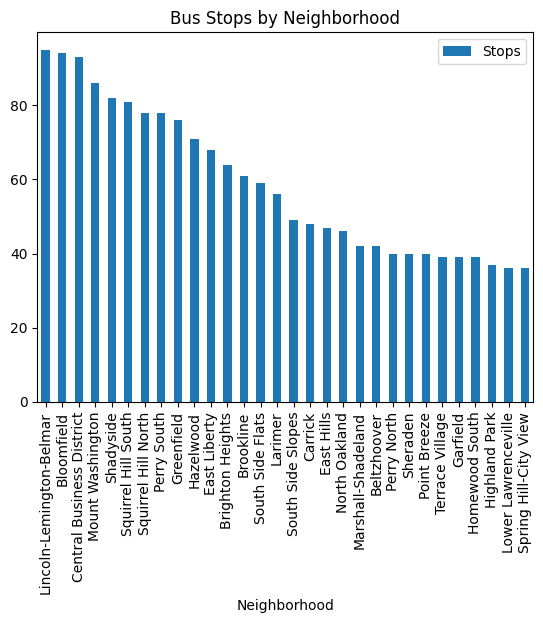

In [37]:
plt = neighborhoods_sorted.iloc[:30].plot(kind='bar', x="Neighborhood", y="Stops", title="Bus Stops by Neighborhood")

Let's also plot the bottom 30 neighborhoods.

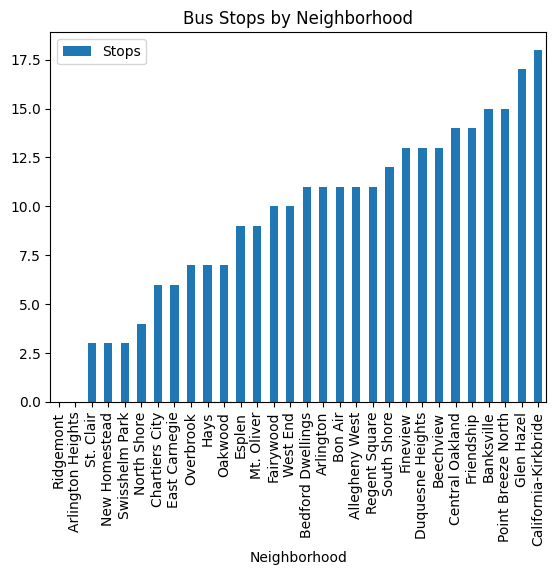

In [38]:
neighborhoods_asc = neighborhoods.sort_values("Stops")
plt2 = neighborhoods_asc.iloc[:30].plot(kind='bar', x="Neighborhood", y="Stops", title="Bus Stops by Neighborhood")

Finally, let's add bus stops to the original geodataframe and plot it.

<AxesSubplot: >

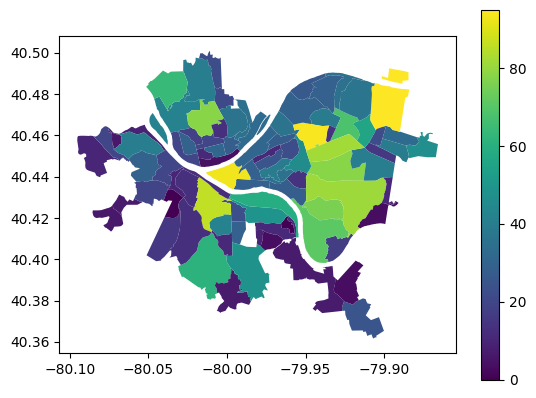

In [40]:
neighborhood_data["Bus_Stops"] = neighborhoods["Stops"]

neighborhood_data.plot(column="Bus_Stops", legend=True)

This concludes the analysis for the number of bus stops in each neighborhood.